In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

In [3]:
# Load the dataset (you'll need to replace this with your actual data loading method)
def load_taxi_data():
    df1 = pd.read_parquet('../data/raw/yellow_tripdata_2024-01.parquet')
    df2 = pd.read_parquet('../data/raw/yellow_tripdata_2024-02.parquet')
    df3 = pd.read_parquet('../data/raw/yellow_tripdata_2024-03.parquet')
    df4 = pd.read_parquet('../data/raw/yellow_tripdata_2024-04.parquet')
    df5 = pd.read_parquet('../data/raw/yellow_tripdata_2024-05.parquet')
    df6 = pd.read_parquet('../data/raw/yellow_tripdata_2024-06.parquet')
    df = pd.concat([df1, df2, df3, df4, df5, df6])
    return df

In [13]:
def downcast_dtypes(df):
    # Downcast numerical columns to save memory
    float_cols = df.select_dtypes(include=['float64']).columns
    int_cols = df.select_dtypes(include=['int64']).columns

    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)

    return df

def preprocess_data(df):
    # Ensure DataFrame is not empty
    if df.empty:
        raise ValueError("The input DataFrame is empty. Please check your dataset.")
    
    # Handle missing values for numeric columns
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Check if numeric columns exist
    if numeric_columns.empty:
        raise ValueError("No numeric columns found in the dataset.")
    
    imputer = SimpleImputer(strategy='median')  # Use median to impute missing numeric values
    df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
    
    # Log transform specified columns to handle skewness
    log_transform_columns = ['fare_amount', 'trip_distance', 'tip_amount', 'total_amount']
    for col in log_transform_columns:
        if col in df.columns:
            # Ensure no negative values before applying log transformation
            df[col] = np.log1p(df[col].clip(lower=0))
    
    # Downcast dtypes to optimize memory
    df = downcast_dtypes(df)
    
    # Feature Engineering
    if 'tpep_pickup_datetime' in df.columns:
        df['pickup_hour'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.hour
        df['pickup_day'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.day_name()
        df['pickup_month'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.month
    
    # Encode categorical variables with one-hot encoding
    categorical_columns = ['pickup_day', 'RatecodeID', 'payment_type']
    for col in categorical_columns:
        if col in df.columns:
            df = pd.get_dummies(df, columns=[col], drop_first=True)
    
    # Drop any remaining rows with NaN values as a last resort
    df.dropna(inplace=True)
    
    return df


In [5]:
# Feature Selection and Preparation
def prepare_features(df):
    # Select relevant features for regression
    features = ['tip_amount', 'congestion_surcharge', 'total_amount', 'improvement_surcharge', 'mta_tax', 'VendorID', 'passenger_count', 'extra', 'fare_amount']
    
    # Prepare X and y
    X = df[features]
    y = df['total_amount']
    
    return X, y


In [6]:
# Cross-validation Function (similar to your approach)
def cross_validate_models(X, y, models, dataset_name):
    results = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, model in models.items():
        # Cross-validation with cross_val_score for RMSE
        scores_rmse = cross_val_score(model, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
        mean_cv_rmse = -np.mean(scores_rmse)  # Convert from negative RMSE to positive
        
        # Cross-validation predictions
        y_pred = cross_val_predict(model, X, y, cv=kfold)
        
        # Compute metrics
        rmse_pred = np.sqrt(mean_squared_error(y, y_pred))
        mae_pred = mean_absolute_error(y, y_pred)
        r2_pred = r2_score(y, y_pred)
        
        # Store results
        results.append({
            "Dataset": dataset_name,
            "Model": name,
            "Cross_val_score_RMSE": mean_cv_rmse,
            "Cross_val_predict_RMSE": rmse_pred,
            "Cross_val_predict_MAE": mae_pred,
            "Cross_val_predict_R2": r2_pred
        })
    
    return results

In [7]:
# Feature Selection with Lasso and ElasticNet
def feature_selection_optimization(X, y):
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    # Lasso Feature Selection
    lasso = Lasso(random_state=42)
    lasso.fit(X_scaled, y)
    lasso_features = X.columns[lasso.coef_ != 0]
    
    # ElasticNet Feature Selection
    elasticnet = ElasticNet(random_state=42)
    elasticnet.fit(X_scaled, y)
    elasticnet_features = X.columns[elasticnet.coef_ != 0]
    
    # Combine features
    selected_features = list(set(lasso_features).union(set(elasticnet_features)))
    
    return X[selected_features], y

In [14]:
df = load_taxi_data()
df.head()
# Preprocess the data

    

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [15]:
processed_df = preprocess_data(df)
# print(processed_df)

In [16]:
# Prepare features
X, y = prepare_features(processed_df)

In [17]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42)
}

In [18]:
all_results = []
# 1. Initial Cross-Validation
print("Initial Cross-Validation Results:")
initial_results = cross_validate_models(X, y, models, "Initial Dataset")
all_results.extend(initial_results)

Initial Cross-Validation Results:


In [19]:
# 2. Feature Selection and Optimization
print("\nOptimized Feature Selection Results:")
X_optimized, y_optimized = feature_selection_optimization(X, y)
optimized_results = cross_validate_models(X_optimized, y_optimized, models, "Optimized Dataset")
all_results.extend(optimized_results)


Optimized Feature Selection Results:


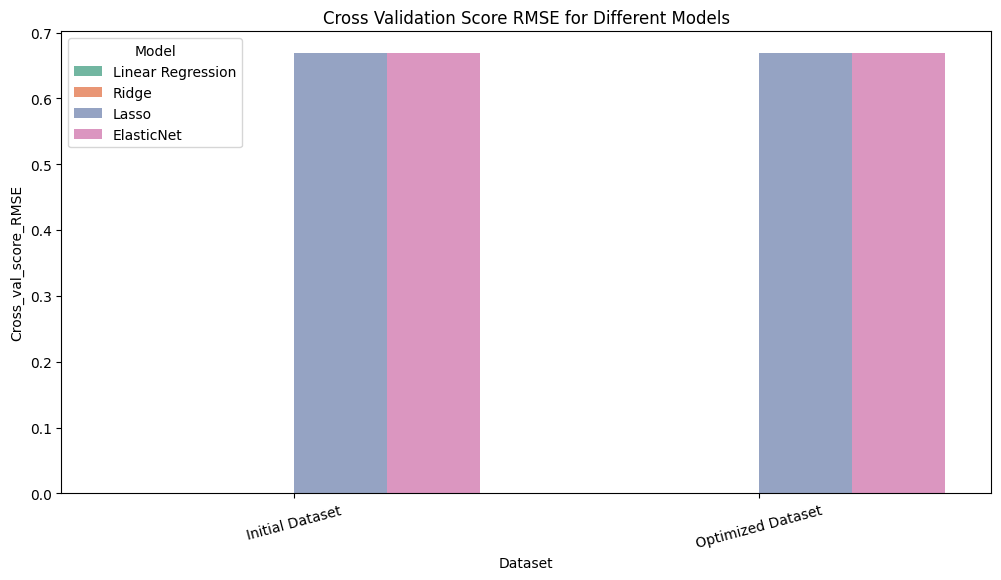


Full Results:
             Dataset              Model  Cross_val_score_RMSE  \
0    Initial Dataset  Linear Regression          1.149045e-12   
1    Initial Dataset              Ridge          8.962150e-07   
2    Initial Dataset              Lasso          6.681633e-01   
3    Initial Dataset         ElasticNet          6.681633e-01   
4  Optimized Dataset  Linear Regression          3.935343e-07   
5  Optimized Dataset              Ridge          1.184528e-05   
6  Optimized Dataset              Lasso          6.681633e-01   
7  Optimized Dataset         ElasticNet          6.681633e-01   

   Cross_val_predict_RMSE  Cross_val_predict_MAE  Cross_val_predict_R2  
0            1.329245e-12           7.961015e-13          1.000000e+00  
1            8.962167e-07           5.907913e-07          1.000000e+00  
2            6.681634e-01           4.550494e-01         -1.045316e-07  
3            6.681634e-01           4.550494e-01         -1.045316e-07  
4            4.328351e-07         

In [20]:
# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_df,
    x="Dataset", y="Cross_val_score_RMSE",
    hue="Model", palette="Set2"
)
plt.title("Cross Validation Score RMSE for Different Models")
plt.ylabel("Cross_val_score_RMSE")
plt.xlabel("Dataset")
plt.xticks(rotation=15)
plt.show()

# Print results
print("\nFull Results:")
print(results_df)
